In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 200,
})

import os
import numpy as np
from irc.manager import AgentManager

rng = np.random.default_rng()

In [2]:
manager = AgentManager('store', defaults='irc-defaults.yaml')

# picking an agent within the sweep range
min_epoch = 18
spec = 'cond-spec.yaml'
cond = manager._spec2cond(spec)
keys = [key for key, _ in manager.completed(min_epoch=min_epoch, cond=cond)]
key = rng.choice(keys)
print(f'{len(keys)} agents trained for at least {min_epoch} epochs, {key} randomly picked.')

config = manager.configs[key]
print("env_param:\n("+', '.join(['{:.3g}'.format(x) for x in config.env_param])+")")
print("gamma: {:.3g}, ent_coef: {:.3g}".format(config.task.gamma, config.task.ent_coef))

689 agents trained for at least 18 epochs, 6B3F005E randomly picked.
env_param:
(0.556, 0.001, 0.1, 0, 0.0449, 0.2, 0.0472, 0.2, 0.04, 0.2)
gamma: 0.983, ent_coef: 0.0338


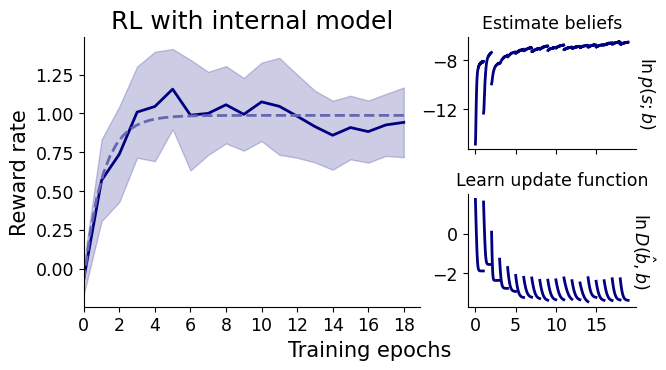

In [3]:
agent, fig = manager.inspect_agent(key, to_plot_stats=True)

In [4]:
max_steps = 120

example_dir = 'store/example-agent'
os.makedirs(example_dir, exist_ok=True)
for e in manager.ckpt['history']:
    agent.load_state_dict(manager.ckpt['history'][e])
    episode = agent.run_one_episode(max_steps=max_steps)
    pos = np.array([info['pos'] for info in episode.infos])
    gaze = np.array([info['gaze'] for info in episode.infos])
    colors = np.array([info['colors'] for info in episode.infos])
    push = episode.actions==agent.model.env._push
    success = episode.rewards>0
    fig, ani = agent.model.env.play_episode(
        pos, gaze, colors, push, success,
    )
    ani.save('{}/epoch-{:02d}.gif'.format(example_dir, e))
    plt.close(fig)

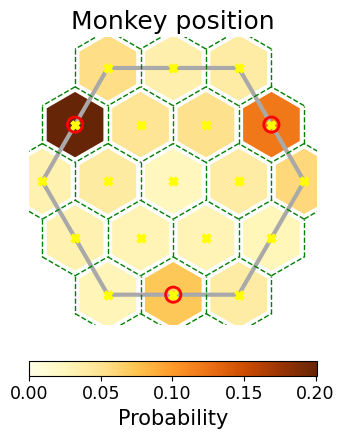

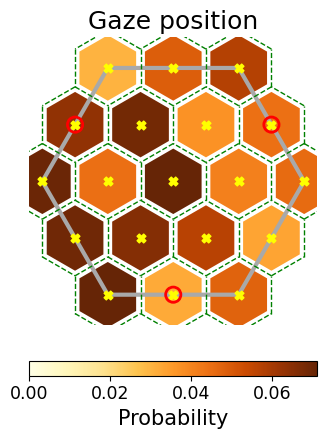

In [5]:
episodes = agent.run_episodes(num_episodes=100, max_steps=max_steps)
pos, gaze = [], []
for episode in episodes:
    for info in episode.infos:
        pos.append(info['pos'])
        gaze.append(info['gaze'])

fig_p, fig_g = agent.model.env.plot_occupancy(pos, gaze)

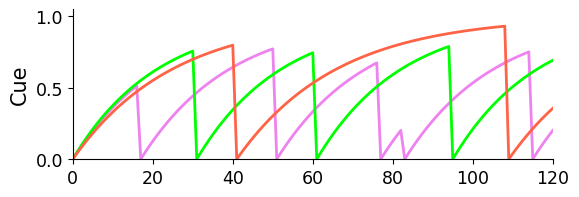

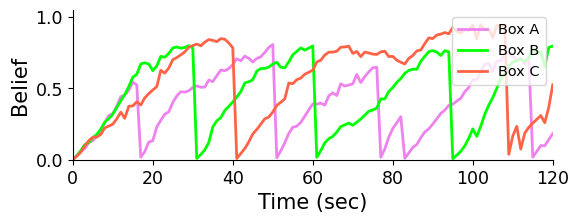

In [6]:
episode = rng.choice(episodes)
cues = np.stack([info['cues'] for info in episode.infos])
probs = agent.model.env.food_probs(episode.beliefs, episode.states, agent.model.p_s)

fig, ani = agent.model.env.play_traces(cues, xlabel='', ylabel='Cue', show_legend=False)
ani.save('{}/agent-cue.gif'.format(example_dir))
fig, ani = agent.model.env.play_traces(probs, ylabel='Belief')
ani.save('{}/agent-belief.gif'.format(example_dir))